In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [42]:
us18_matches = pd.read_csv('tennis_data/2018-usopen-matches.csv')
us18_matches = us18_matches.dropna(axis=1, how='all')

us18_points = pd.read_csv('tennis_data/2018-usopen-points.csv')
us18_points = us18_points.dropna(axis=1, how='all')

In [74]:
# Get all player names from a tourney

def get_player_names(matches):
    return np.unique(np.append(matches.player1.values, matches.player2.values))

# Given a player name and tourney, get their matches
def get_player_points(player, matches, points):
    # Get all match numbers
    match_ids = matches[(matches['player1'] == player) | (matches['player2'] == player)].match_id

    player_points = points[points.match_id.isin(match_ids)]

    return player_points


def get_summary_stats(player, matches, match):
    match_metadata = matches[matches.match_id == match.loc[1].match_id]
    # Get Ace percentage for that match
    if match_metadata.player1[0] == player:
        return match.P1Ace
    else:
        return match.P2Ace

def get_serves(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_serves = player_points[(player_points.match_id.isin(p1_matches)) & (player_points.ServeIndicator == 1)]  

    p2_matches = matches[matches['player2'] == player].match_id
    p2_serves = player_points[(player_points.match_id.isin(p2_matches)) & (player_points.ServeIndicator == 2)]

    player_serves = p1_serves.append(p2_serves)
    #player_serves.reset_index()

    return player_serves

# Function for getting points that were not made by double faulting (the ball was put into play)
def get_plays(player, matches, player_points):
    plays = player_points[(player_points.P1DoubleFault == 0) & (player_points.P2DoubleFault == 0)]
    return plays

def get_net_points(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_nets = player_points[(player_points.match_id.isin(p1_matches)) & (player_points.P1NetPoint == 1)]  

    p2_matches = matches[matches['player2'] == player].match_id
    p2_nets = player_points[(player_points.match_id.isin(p2_matches)) & (player_points.P2NetPoint == 1)]

    player_nets = p1_nets.append(p2_nets)

    return player_nets

def get_distances(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_dists = player_points[(player_points.match_id.isin(p1_matches))].P1DistanceRun 

    p2_matches = matches[matches['player2'] == player].match_id
    p2_dists = player_points[(player_points.match_id.isin(p2_matches))].P2DistanceRun

    return (np.sum(p1_dists) + np.sum(p2_dists))

def get_unforced_errors(player, matches, player_points):
    p1_matches = matches[matches['player1'] == player].match_id
    p1_unf_err = player_points[(player_points.match_id.isin(p1_matches))].P1UnfErr

    p2_matches = matches[matches['player2'] == player].match_id
    p2_unf_err = player_points[(player_points.match_id.isin(p2_matches))].P2UnfErr

    return (np.sum(p1_unf_err) + np.sum(p2_unf_err))


# Given a list of players, we want to go through the entire dataset and calculate a running average of their stats
Some assumptions made by this model are that players do not significantly change their playstlye throughout this calcualtion period 2011-2020.

In [77]:
colnames = ['nServes', 'Ace_Avg', 'SSpeed', 'nPlays', 'nNets', 'Net_Avg', 'Net_Win', 'Rally_Ct', 'Unf_Err']
player_stats = pd.DataFrame(index=[''], columns=colnames)

#player_stats.loc['Roger Federer'] =  [2, 0.5]

nadal_points = get_player_points('Rafael Nadal', us18_matches, us18_points)

tours = ['ausopen', 'frenchopen', 'usopen', 'wimbledon']
players = ['Rafael Nadal']

# Triply four loop dont tell my CS profs ;(
for year in np.arange(2017, 2018):
    for tour in tours:
        matches = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-matches.csv')
        points = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-points.csv')

        players = list(set(np.append(matches.player1.values, matches.player2.values)))

        for player in players:
            player_points = get_player_points(player, matches, points)

            if player not in player_stats.index:
                player_stats.loc[player] = np.zeros(len(colnames))
            
            update_row = []

            #-----------------------------------------------------------
            # Serve Stats
            #-----------------------------------------------------------
                # Calculate running average of Aces
            player_serves = get_serves(player, matches, points)

            ace_avg = (np.sum(player_serves.P1Ace) + np.sum(player_serves.P2Ace) + player_stats.loc[player].nServes * player_stats.loc[player].Ace_Avg) \
                / (np.shape(player_serves)[0] + player_stats.loc[player].nServes)
                
            update_row.append(np.shape(player_serves)[0] + player_stats.loc[player].nServes)
            update_row.append(ace_avg)

                # Calculate running average serve speed
            serve_speed_avg = (np.sum(player_serves.Speed_MPH) + player_stats.loc[player].nServes * player_stats.loc[player].SSpeed) \
                / (np.shape(player_serves)[0] + player_stats.loc[player].nServes)

            update_row.append(serve_speed_avg)

            #-----------------------------------------------------------
            # Net Stats
            #-----------------------------------------------------------
            player_plays = get_plays(player, matches, points)
            player_nets = get_net_points(player, matches, points)
                # Calculate running average of times player played the net
            avg_net_plays = (np.sum(player_nets.P1NetPoint) + np.sum(player_nets.P2NetPoint) + player_stats.loc[player].nPlays * player_stats.loc[player].Net_Avg) \
                / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)

            avg_net_wins = (np.sum(player_nets.P1NetPointWon) + np.sum(player_nets.P2NetPointWon) + player_stats.loc[player].nNets * player_stats.loc[player].Net_Win) \
                / (np.shape(player_nets)[0] + player_stats.loc[player].nNets)


            update_row.append(np.shape(player_plays)[0] + player_stats.loc[player].nPlays)
            update_row.append(np.shape(player_nets)[0] + player_stats.loc[player].nNets)
            update_row.append(avg_net_plays)
            update_row.append(avg_net_wins)

            #-----------------------------------------------------------
            # Gameplay Stats
            #-----------------------------------------------------------
                # Avg Rally length
            avg_rally = (np.sum(player_plays.RallyCount) + player_stats.loc[player].nPlays * player_stats.loc[player].Rally_Ct) \
                / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)

            update_row.append(avg_rally)

                # Unforced error rate (consistency measure)
            player_errors = get_unforced_errors(player, matches, player_plays)
            avg_err = (player_errors + player_stats.loc[player].nPlays * player_stats.loc[player].Unf_Err) \
                / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)
            
            update_row.append(avg_err)


            player_stats.loc[player] = update_row


                # Avg distance ran during a point
            # player_dists = get_distances(player, matches, player_plays)
            # avg_dist = (player_dists + player_stats.loc[player].nPlays * player_stats.loc[player].Dists) \
                # / (np.shape(player_plays)[0] + player_stats.loc[player].nPlays)

            # update_row.append(avg_dist)


<ipython-input-77-c8fced6a0275>:33: RuntimeWarning: invalid value encountered in double_scalars
  ace_avg = (np.sum(player_serves.P1Ace) + np.sum(player_serves.P2Ace) + player_stats.loc[player].nServes * player_stats.loc[player].Ace_Avg) \
<ipython-input-77-c8fced6a0275>:40: RuntimeWarning: invalid value encountered in double_scalars
  serve_speed_avg = (np.sum(player_serves.Speed_MPH) + player_stats.loc[player].nServes * player_stats.loc[player].SSpeed) \
<ipython-input-77-c8fced6a0275>:54: RuntimeWarning: invalid value encountered in double_scalars
  avg_net_wins = (np.sum(player_nets.P1NetPointWon) + np.sum(player_nets.P2NetPointWon) + player_stats.loc[player].nNets * player_stats.loc[player].Net_Win) \


In [84]:
player_stats = player_stats.dropna()
player_stats

,nServes,Ace_Avg,SSpeed,nPlays,nNets,Net_Avg,Net_Win,Rally_Ct,Unf_Err
Elina Svitolina,1220.0,0.036885,77.222951,156179.0,146.0,0.000935,0.732877,3.373924,0.002075
Kateryna Kozlova,152.0,0.026316,81.960526,83428.0,10.0,0.000120,0.800000,3.314535,0.000408
Novak Djokovic,1089.0,0.053260,97.203857,127448.0,183.0,0.001436,0.726776,3.182059,0.002558
Mirjana Lucic Baroni,719.0,0.037552,72.287900,156179.0,110.0,0.000704,0.700000,3.373924,0.001998
Joao Sousa,420.0,0.064286,48.473810,127448.0,49.0,0.000384,0.734694,3.182059,0.000863
...,...,...,...,...,...,...,...,...,...
Brydan Klein,90.0,0.066667,0.000000,44020.0,19.0,0.000432,0.842105,2.930986,0.000363
Zarina Diyas,224.0,0.022321,29.566964,44020.0,48.0,0.001090,0.833333,2.930986,0.001567
Garbine Muguruza,412.0,0.038835,91.189320,44020.0,124.0,0.002817,0.741935,2.930986,0.002431
Anastasia Potapova,41.0,0.024390,0.000000,44020.0,15.0,0.000341,0.733333,2.930986,0.000227


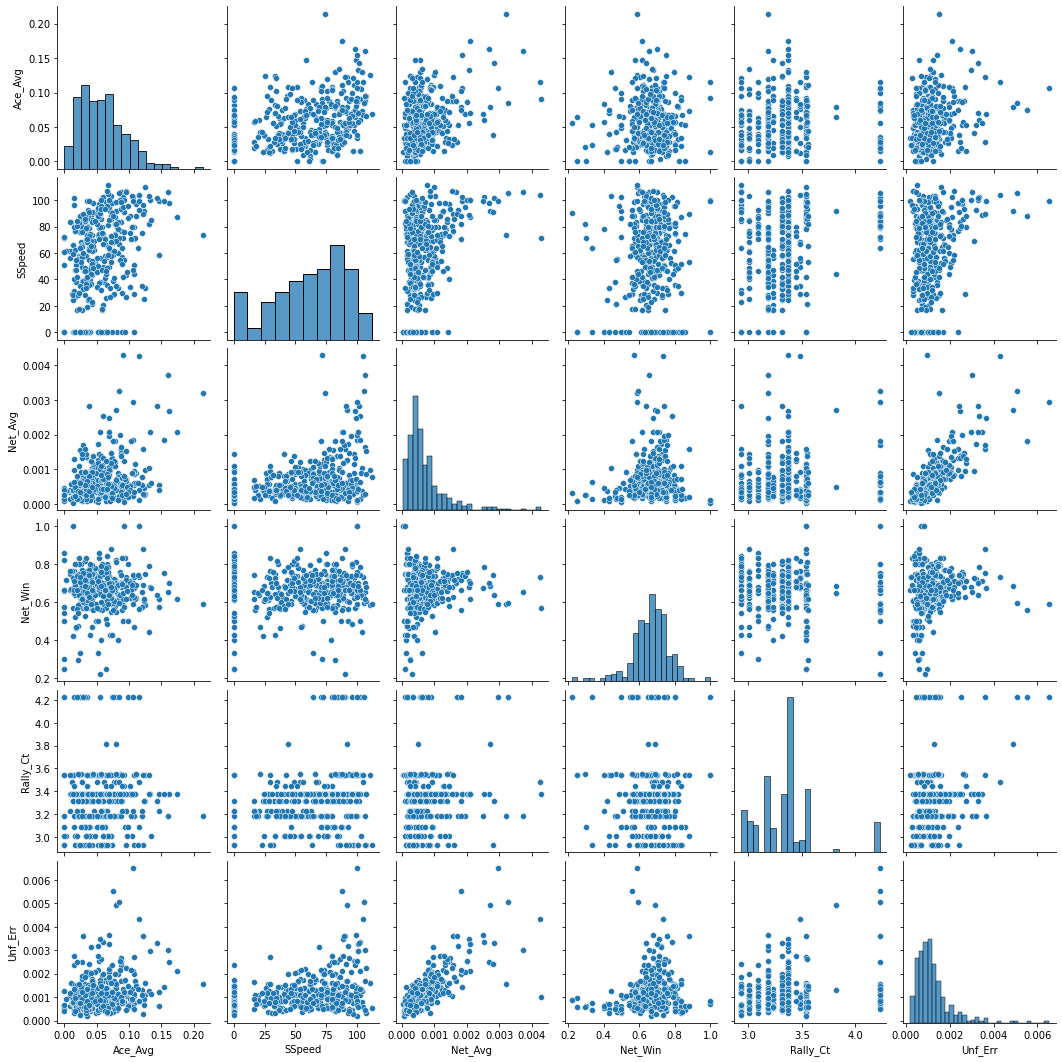

In [85]:
predictors = ['Ace_Avg', 'SSpeed', 'Net_Avg', 'Net_Win', 'Rally_Ct', 'Unf_Err']

player_stats_preds = player_stats[predictors]

sns.pairplot(player_stats_preds)

# Clustering

In [91]:
scaler = StandardScaler()
player_stats_scaled = scaler.fit_transform(player_stats_preds)

kmeans = KMeans(
    init='random',
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=98
)

kmeans.fit(player_stats_scaled)

KMeans(init='random', n_clusters=4, random_state=98)

In [93]:
kmeans.cluster_centers_

array([[-0.25439384,  0.67478742, -0.38055772, -0.16505116,  3.09125584,
        -0.12783638],
       [ 0.97827329,  0.9854012 ,  2.20882422,  0.27514291,  0.3924897 ,
         2.10527345],
       [-0.63863938, -1.07779056, -0.44255549, -0.3371425 , -0.4019692 ,
        -0.43911723],
       [ 0.21024899,  0.38969894, -0.14682924,  0.16282108, -0.11787935,
        -0.15083917]])